## Comparing performance of NeuralProphet vs Prophet with additional regressors and default parameters.

1. Importing libraries

In [32]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
from prophet import Prophet 
import holidays
from neuralprophet import set_random_seed

set_random_seed(42)
seed = 42
np.random.seed(seed) 
random.seed(seed)


2. Importing daily crime count with regressor data.

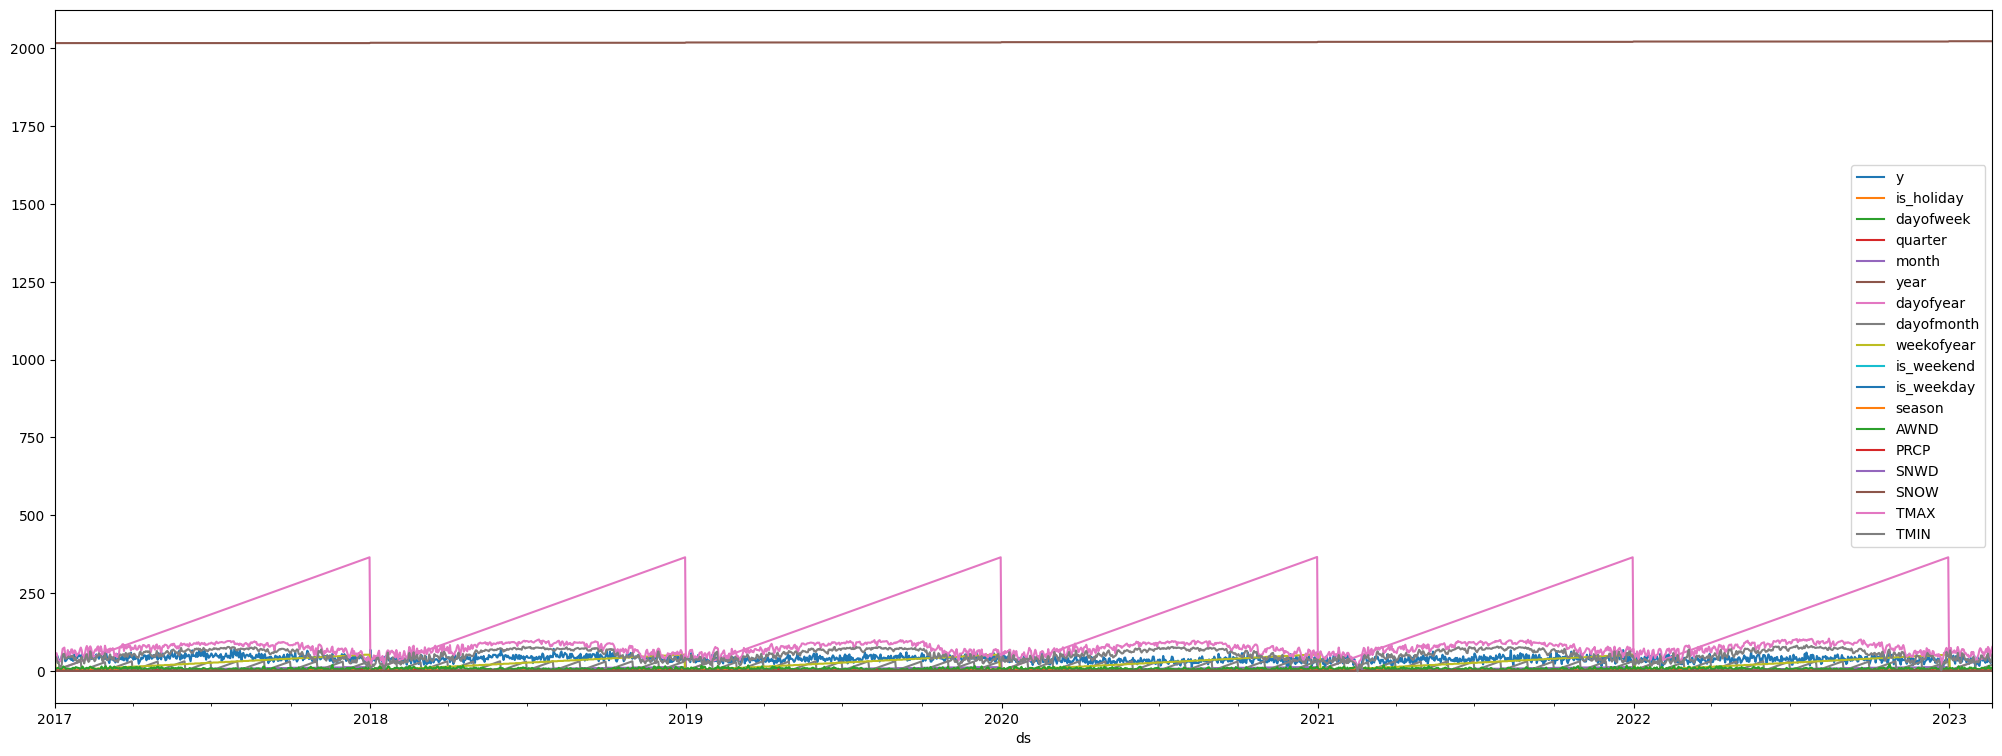

In [33]:
df = pd.read_csv("../../data/final-lrpd-data.csv")
import reduce_mem_usage
df = reduce_mem_usage.reduce_mem_usage(df)
regressors = ['is_holiday', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'is_weekend', 'is_weekday',
       'season', 'AWND', 'PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN']
df = df[["ds", "y"] + regressors]
df["ds"] = pd.to_datetime(df["ds"])
df.set_index('ds').plot(figsize=(25, 9))
df['pre_covid'] = pd.to_datetime(df['ds']) < pd.to_datetime('2020-03-21')
df['post_covid'] = ~df['pre_covid']

In [34]:
train = df[:int(0.8 * (len(df)))]
test = df[int(0.8 * (len(df))):]

df_half = df[:int(0.5 * (len(df)))]
train_half = df_half[:int(0.8 * (len(df_half)))]
test_half = df_half[int(0.8 * (len(df_half))):]

df_quarter = df[:int(0.25 * (len(df)))]
train_quarter = df_quarter[:int(0.8 * (len(df_quarter)))]
test_quarter = df_quarter[int(0.8 * (len(df_quarter))):]

train.shape, test.shape

((1793, 21), (449, 21))

3. Fitting the all models with default settings and additional regressors/seasonality modifiers.

In [35]:
def neural_prophet(train, test):
    m = NeuralProphet(
    )
    m = m.add_country_holidays(country_name='US')

    for regressor in regressors:
        m = m.add_future_regressor(regressor)

    m.add_seasonality(
        name='weekly_pre_covid',
        period=7,
        fourier_order=3,
        condition_name='pre_covid',
    )
    m.add_seasonality(
        name='weekly_post_covid',
        period=7,
        fourier_order=3,
        condition_name='post_covid',
    )
    
    m.fit(train)
    future = m.make_future_dataframe(train, periods=test.shape[0], regressors_df=test[regressors + ['pre_covid', 'post_covid']])
    future['pre_covid'] = pd.to_datetime(future['ds']) < pd.to_datetime('2020-03-21')
    future['post_covid'] = ~future['pre_covid']
    
    forecast = m.predict(future)
    forecast_on_train = m.predict(train)

    toTest = test.merge(forecast[['ds', 'yhat1']], how='left', on='ds')
    rmse = mean_squared_error(toTest['y'], toTest['yhat1'], squared=False)
    return rmse

def fb_prophet(train, test):
    np.random.seed(42)
    m = Prophet()
    m.add_country_holidays(country_name='US')
    
    m.add_seasonality(
        name='weekly_pre_covid',
        period=7,
        fourier_order=3,
        condition_name='pre_covid',
    )
    m.add_seasonality(
        name='weekly_post_covid',
        period=7,
        fourier_order=3,
        condition_name='post_covid',
    )
    
    for f in regressors:
        m.add_regressor(f)

    m.fit(train)

    future_train = train.drop(columns=['y']).copy()
    future_train['pre_covid'] = pd.to_datetime(future_train['ds']) < pd.to_datetime('2020-03-21')
    future_train['post_covid'] = ~future_train['pre_covid']

    for f in regressors:
        future_train[f] = df[f][:len(train)]

    forecast_train = m.predict(future_train)

    # Evaluate performance on the train set
    y_true_train = train['y'].values
    y_pred_train = forecast_train['yhat'].values[:len(train)]
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

    future_test = test.drop(columns=['y']).copy()
    future_test['pre_covid'] = pd.to_datetime(future_test['ds']) < pd.to_datetime('2020-03-21')
    future_test['post_covid'] = ~future_test['pre_covid']

    for f in regressors:
        future_test[f] = df[f][len(train):]

    forecast_test = m.predict(future_test)

    # Evaluate performance on the test set
    y_true_test = test['y'].values
    y_pred_test = forecast_test['yhat'].values[-len(test):]
    rmse_test_tuned = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    
    return rmse_test_tuned


In [36]:
fb_rmse_full_data = fb_prophet(train, test)
neural_rmse_full_data = neural_prophet(train, test)

fb_rmse_half_data = fb_prophet(train_half, test_half)
neural_rmse_half_data = neural_prophet(train_half, test_half)

fb_rmse_quarter_data = fb_prophet(train_quarter, test_quarter)
neural_rmse_quarter_data = neural_prophet(train_quarter, test_quarter)



20:16:01 - cmdstanpy - INFO - Chain [1] start processing
20:16:01 - cmdstanpy - INFO - Chain [1] done processing
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 163
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number for the learning rate finder (231). The results might not be optimal.


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.777% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.777% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 57it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.944% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 57it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
20:16:55 - cmdstanpy - INFO - Chain [1] start processing
20:16:55 - cmdstanpy - INFO - Chain [1] done processing
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.888% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 201
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (56) is too small than the required

Finding best initial lr:   0%|          | 0/224 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.888% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.556% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.556% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 56it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.888% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.888% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 56it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
20:18:04 - cmdstanpy - INFO - Chain [1] start processing
20:18:04 - cmdstanpy - INFO - Chain [1] done processing
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.777% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-se

Finding best initial lr:   0%|          | 0/218 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.777% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.107% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.107% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 28it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.777% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.777% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 28it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [37]:
print("NeuralProphet RMSE: ", neural_rmse_full_data)
print("Prophet RMSE: ", fb_rmse_full_data)

print("NeuralProphet RMSE (half data): ", neural_rmse_half_data)
print("Prophet RMSE (half data): ", fb_rmse_half_data)

print("NeuralProphet RMSE (quarter data): ", neural_rmse_quarter_data)
print("Prophet RMSE (quarter data): ", fb_rmse_quarter_data)

NeuralProphet RMSE:  10.90610954790818
Prophet RMSE:  8.763423826126866
NeuralProphet RMSE (half data):  11.623950525178094
Prophet RMSE (half data):  7.791095678892988
NeuralProphet RMSE (quarter data):  13.42640527683989
Prophet RMSE (quarter data):  7.917319700263102
